# Machine Learning 

### Importing libraries

In [1]:
import numpy as np
import uproot
import vector
import awkward
import boost_histogram as bh
import matplotlib.pyplot as plt
import mplhep as hep
import sklearn as skl
import torch 
seed_value = 420 
from numpy.random import seed
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
import itertools
from sklearn.inspection import permutation_importance

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions

### Plotting

In [2]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(awkward.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

### Combinations

In [3]:
def n_combinations(particles, n):
    valid_jets = particles[awkward.num(particles) >= n]
    indices = np.array(list(itertools.combinations(range(awkward.max(awkward.num(valid_jets))), n)))
    combinations = valid_jets[:, indices]
    return combinations

## Extracting Data

In [11]:
tree3j = uproot.open(directory + "3tops_tttj_skimmed_combined.root")
tree3W = uproot.open(directory + "3tops_tttW_skimmed_combined.root")
tree4 = uproot.open(directory + "4tops_inclusive_17july_combined.root")

events_4t_jets = tree4["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.T','Jet.Mass','Jet.Flavor','Jet.BTag','Jet.Charge'])
events_4t_electrons = tree4["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.T','Electron.Charge','Electron.Particle'])
events_4t_electrons['Electron.Mass'] = np.ones_like(events_4t_electrons['Electron.PT']) * 0.511E-3
events_4t_muons = tree4["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi','Muon.T','Muon.Charge','Muon.Particle'])
events_4t_muons['Muon.Mass'] = np.ones_like(events_4t_muons['Muon.PT']) * 0.1057

jets_pt_4t = events_4t_jets['Jet.PT']
jets_eta_4t = events_4t_jets['Jet.Eta']
jets_phi_4t = events_4t_jets['Jet.Phi']
jets_mass_4t = events_4t_jets['Jet.Mass']

leptons_pt_4t = awkward.concatenate((events_4t_electrons['Electron.PT'],events_4t_muons['Muon.PT']), axis=1)
leptons_eta_4t = awkward.concatenate((events_4t_electrons['Electron.Eta'],events_4t_muons['Muon.Eta']), axis=1)
leptons_phi_4t = awkward.concatenate((events_4t_electrons['Electron.Phi'],events_4t_muons['Muon.Phi']), axis=1)
leptons_mass_4t = awkward.concatenate((events_4t_electrons['Electron.Mass'],events_4t_muons['Muon.Mass']), axis=1)

jets_4t = vector.zip({'pt':jets_pt_4t,'eta':jets_eta_4t,'phi':jets_phi_4t,'mass':jets_mass_4t})
leptons_4t = vector.zip({'pt':leptons_pt_4t,'eta':leptons_eta_4t,'phi':leptons_phi_4t,'mass':leptons_mass_4t})
all_products_4t = awkward.concatenate((jets_4t,leptons_4t), axis=1)

events_3tj_jets = tree3j["Delphes;1"]["Jet"].arrays(['Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.BTag'])
events_3tj_electrons = tree3j["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.Charge','Electron.Particle'])
events_3tj_electrons['Mass'] = np.ones_like(events_3tj_electrons['Electron.PT'])*0.511E-3
events_3tj_muons = tree3j["Delphes;1"]["Muon"].arrays(['Muon.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.Charge', 'Muon.Particle'])
events_3tj_muons['Mass'] = np.ones_like(events_3tj_muons['Muon.PT'])*0.1057

events_3tW_jets = tree3W["Delphes;1"]["Jet"].arrays(['Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.BTag'])
events_3tW_electrons = tree3W["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.Charge','Electron.Particle'])
events_3tW_electrons['Mass'] = np.ones_like(events_3tW_electrons['Electron.PT'])*0.511E-3
events_3tW_muons = tree3W["Delphes;1"]["Muon"].arrays(['Muon.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.Charge', 'Muon.Particle'])
events_3tW_muons['Mass'] = np.ones_like(events_3tW_muons['Muon.PT'])*105.7

jets_pt_3tj = events_3tj_jets['Jet.PT']
jets_eta_3tj = events_3tj_jets['Jet.Eta']
jets_phi_3tj = events_3tj_jets['Jet.Phi']
jets_mass_3tj = events_3tj_jets['Jet.Mass']

electrons_pt_3tj = events_3tj_electrons['Electron.PT']
electrons_eta_3tj = events_3tj_electrons['Electron.Eta']
electrons_phi_3tj = events_3tj_electrons['Electron.Phi']
electrons_mass_3tj = events_3tj_electrons['Mass']

muons_pt_3tj = events_3tj_muons['Muon.PT']
muons_eta_3tj = events_3tj_muons['Muon.Eta']
muons_phi_3tj = events_3tj_muons['Muon.Phi']
muons_mass_3tj = events_3tj_muons['Mass']

jets_pt_3tW = events_3tW_jets['Jet.PT']
jets_eta_3tW = events_3tW_jets['Jet.Eta']
jets_phi_3tW = events_3tW_jets['Jet.Phi']
jets_mass_3tW = events_3tW_jets['Jet.Mass']

electrons_pt_3tW = events_3tW_electrons['Electron.PT']
electrons_eta_3tW = events_3tW_electrons['Electron.Eta']
electrons_phi_3tW = events_3tW_electrons['Electron.Phi']
electrons_mass_3tW = events_3tW_electrons['Mass']

muons_pt_3tW = events_3tW_muons['Muon.PT']
muons_eta_3tW = events_3tW_muons['Muon.Eta']
muons_phi_3tW = events_3tW_muons['Muon.Phi']
muons_mass_3tW = events_3tW_muons['Mass']

leptons_pt_3tW = awkward.concatenate([electrons_pt_3tW,muons_pt_3tW],axis=1)
leptons_eta_3tW = awkward.concatenate([electrons_eta_3tW,muons_eta_3tW],axis=1)
leptons_phi_3tW = awkward.concatenate([electrons_phi_3tW,muons_phi_3tW],axis=1)
leptons_mass_3tW = awkward.concatenate([electrons_mass_3tW,muons_mass_3tW],axis=1)

leptons_pt_3tj = awkward.concatenate([electrons_pt_3tj,muons_pt_3tj],axis=1)
leptons_eta_3tj = awkward.concatenate([electrons_eta_3tj,muons_eta_3tj],axis=1)
leptons_phi_3tj = awkward.concatenate([electrons_phi_3tj,muons_phi_3tj],axis=1)
leptons_mass_3tj = awkward.concatenate([electrons_mass_3tj,muons_mass_3tj],axis=1)

leptons_pt_3t = awkward.concatenate([leptons_pt_3tW,leptons_pt_3tj])
leptons_eta_3t = awkward.concatenate([leptons_eta_3tW,leptons_eta_3tj])
leptons_phi_3t = awkward.concatenate([leptons_phi_3tW,leptons_phi_3tj])
leptons_mass_3t = awkward.concatenate([leptons_mass_3tW,leptons_mass_3tj])

jets_pt_3t = awkward.concatenate([jets_pt_3tW,jets_pt_3tj])
jets_eta_3t = awkward.concatenate([jets_eta_3tW,jets_eta_3tj])
jets_phi_3t = awkward.concatenate([jets_phi_3tW,jets_phi_3tj])
jets_mass_3t = awkward.concatenate([jets_mass_3tW,jets_mass_3tj])

leptons_3t = vector.zip({'pt':leptons_pt_3t,'eta':leptons_eta_3t,'phi':leptons_phi_3t,'mass':leptons_mass_3t})
jets_3t = vector.zip({'pt':jets_pt_3t,'eta':jets_eta_3t,'phi':jets_phi_3t,'mass':jets_mass_3t})
all_products_3t = awkward.concatenate((jets_3t,leptons_3t), axis=1)

In [12]:
lepton_charges_4t = awkward.concatenate((events_4t_electrons['Electron.Charge'], events_4t_muons['Muon.Charge']), axis=1)
lepton_charges_3tW = awkward.concatenate((events_3tW_electrons['Electron.Charge'], events_3tW_muons['Muon.Charge']), axis=1)
lepton_charges_3tj = awkward.concatenate((events_3tj_electrons['Electron.Charge'], events_3tj_muons['Muon.Charge']), axis=1)
lepton_charges_3t = awkward.concatenate((lepton_charges_3tW, lepton_charges_3tj))

In [13]:
filtered_jets_3t = jets_3t[(awkward.num(leptons_3t)>=2) & (awkward.num(jets_3t)>=3)]
filtered_leptons_3t = leptons_3t[(awkward.num(jets_3t)>=3) & (awkward.num(leptons_3t)>=2)]
filtered_lepton_charges_3t = lepton_charges_3t[(awkward.num(jets_3t)>=3) & (awkward.num(leptons_3t)>=2)]

jets_3t = filtered_jets_3t
leptons_3t = filtered_leptons_3t
lepton_charges_3t = filtered_lepton_charges_3t

filtered_jets_4t = jets_4t[(awkward.num(leptons_4t)>=2) & (awkward.num(jets_4t)>=3)]
filtered_leptons_4t = leptons_4t[(awkward.num(jets_4t)>=3) & (awkward.num(leptons_4t)>=2)]
filtered_lepton_charges_4t = lepton_charges_4t[(awkward.num(jets_4t)>=3) & (awkward.num(leptons_4t)>=2)]

jets_4t = filtered_jets_4t
leptons_4t = filtered_leptons_4t
lepton_charges_4t = filtered_lepton_charges_4t

## Sorting

In [14]:
sorted_indices = np.argsort(jets_4t.rho)
trans_sorted_4t = jets_4t[sorted_indices]

highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':jets_4t.m[:,-1]})
second_highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':jets_4t.m[:,-2]})
third_highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-3],'eta':trans_sorted_4t.eta[:,-3],'phi':trans_sorted_4t.phi[:,-3], 'mass':jets_4t.m[:,-3]})
lowest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':jets_4t.m[:,0]})

sorted_indices = np.argsort(jets_3t.rho)
trans_sorted_3t = jets_3t[sorted_indices]

highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':jets_3t.m[:,-1]})
second_highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':jets_3t.m[:,-2]})
third_highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-3],'eta':trans_sorted_3t.eta[:,-3],'phi':trans_sorted_3t.phi[:,-3], 'mass':jets_3t.m[:,-3]})
lowest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':jets_3t.m[:,0]})

In [15]:
sorted_indices = np.argsort(jets_4t.eta)
trans_sorted_4t = jets_4t[sorted_indices]

highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':jets_4t.m[:,-1]})
second_highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':jets_4t.m[:,-2]})
third_highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-3],'eta':trans_sorted_4t.eta[:,-3],'phi':trans_sorted_4t.phi[:,-3], 'mass':jets_4t.m[:,-3]})
lowest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':jets_4t.m[:,0]})

sorted_indices = np.argsort(jets_3t.eta)
trans_sorted_3t = jets_3t[sorted_indices]

highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':jets_3t.m[:,-1]})
second_highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':jets_3t.m[:,-2]})
third_highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-3],'eta':trans_sorted_3t.eta[:,-3],'phi':trans_sorted_3t.phi[:,-3], 'mass':jets_3t.m[:,-3]})
lowest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':jets_3t.m[:,0]})

In [16]:
sorted_indices = np.argsort(jets_4t.phi)
trans_sorted_4t = jets_4t[sorted_indices]

highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':jets_4t.m[:,-1]})
second_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':jets_4t.m[:,-2]})
third_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-3],'eta':trans_sorted_4t.eta[:,-3],'phi':trans_sorted_4t.phi[:,-3], 'mass':jets_4t.m[:,-3]})
lowest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':jets_4t.m[:,0]})

sorted_indices = np.argsort(jets_3t.phi)
trans_sorted_3t = jets_3t[sorted_indices]

highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':jets_3t.m[:,-1]})
second_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':jets_3t.m[:,-2]})
third_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-3],'eta':trans_sorted_3t.eta[:,-3],'phi':trans_sorted_3t.phi[:,-3], 'mass':jets_3t.m[:,-3]})
lowest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':jets_3t.m[:,0]})

In [17]:
sorted_indices = np.argsort(leptons_4t.rho)
trans_sorted_4t = leptons_4t[sorted_indices]

highest_pt_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':leptons_4t.m[:,-1]})
lowest_pt_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':leptons_4t.m[:,0]})

sorted_indices = np.argsort(leptons_3t.rho)
trans_sorted_3t = leptons_3t[sorted_indices]

highest_pt_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':leptons_3t.m[:,-1]})
lowest_pt_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':leptons_3t.m[:,0]})

In [18]:
sorted_indices = np.argsort(leptons_4t.eta)
trans_sorted_4t = leptons_4t[sorted_indices]

highest_eta_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':leptons_4t.m[:,-1]})
lowest_eta_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':leptons_4t.m[:,0]})

sorted_indices = np.argsort(leptons_3t.eta)
trans_sorted_3t = leptons_3t[sorted_indices]

highest_eta_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':leptons_3t.m[:,-1]})
lowest_eta_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':leptons_3t.m[:,0]})

In [19]:
sorted_indices = np.argsort(leptons_4t.phi)
trans_sorted_4t = leptons_4t[sorted_indices]

highest_phi_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':leptons_4t.m[:,-1]})
lowest_phi_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':leptons_4t.m[:,0]})

sorted_indices = np.argsort(leptons_3t.phi)
trans_sorted_3t = leptons_3t[sorted_indices]

highest_phi_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':leptons_3t.m[:,-1]})
lowest_phi_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':leptons_3t.m[:,0]})

## Machine learning

### Defining function

### Data conversions

In [22]:
jets_4t_total_4 = np.sum(jets_4t, axis=1)
jets_4t_H_t = np.sum(jets_4t.pt, axis=1)
jets_pt_balance_4t = jets_4t_total_4.pt/jets_4t_H_t

leptons_4t_total_4 = np.sum(leptons_4t, axis=1)
leptons_4t_H_t = np.sum(leptons_4t.pt, axis=1)
leptons_pt_balance_4t = leptons_4t_total_4.pt/leptons_4t_H_t

jets_3t_total_4 = np.sum(jets_3t, axis=1)
jets_3t_H_t = np.sum(jets_3t.pt, axis=1)
jets_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

leptons_3t_total_4 = np.sum(leptons_3t, axis=1)
leptons_3t_H_t = np.sum(leptons_3t.pt, axis=1)
leptons_pt_balance_3t = leptons_3t_total_4.pt/leptons_3t_H_t

total_4_3t = np.sum(all_products_3t, axis=1)
H_t_3t = np.sum(all_products_3t.pt, axis=1)
pt_balance_3t = total_4_3t.pt/H_t_3t

total_4_4t = np.sum(all_products_4t, axis=1)
H_t_4t = np.sum(all_products_4t.pt, axis=1)
pt_balance_4t = total_4_4t.pt/H_t_4t

In [24]:
sum_pt_jets_3t = np.sum(jets_3t.pt, axis=1)

S_xy_jets_3t = np.zeros((len(jets_3t),2,2))


S_xy_jets_3t[:,0,0] = np.sum(jets_3t.px**2/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,0,1] = np.sum((jets_3t.px*jets_3t.py)/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,1,0] = S_xy_jets_3t[:,0,1]
S_xy_jets_3t[:,1,1] = np.sum(jets_3t.py**2/ jets_3t.pt, axis=1)


S_xy_jets_3t = S_xy_jets_3t/sum_pt_jets_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t = np.linalg.eigvalsh(S_xy_jets_3t)

sphericity_jets_3t = 2*np.min(eigenvalues_jets_3t, axis=1)/np.sum(eigenvalues_jets_3t, axis=1)

sum_pt_jets_4t = np.sum(jets_4t.pt, axis=1)

S_xy_jets_4t = np.zeros((len(jets_4t),2,2))


S_xy_jets_4t[:,0,0] = np.sum(jets_4t.px**2/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,0,1] = np.sum((jets_4t.px*jets_4t.py)/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,1,0] = S_xy_jets_4t[:,0,1]
S_xy_jets_4t[:,1,1] = np.sum(jets_4t.py**2/ jets_4t.pt, axis=1)


S_xy_jets_4t = S_xy_jets_4t/sum_pt_jets_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t = np.linalg.eigvalsh(S_xy_jets_4t)

sphericity_jets_4t = 2*np.min(eigenvalues_jets_4t, axis=1)/np.sum(eigenvalues_jets_4t, axis=1)

sum_pt_leptons_3t = np.sum(leptons_3t.pt, axis=1)

S_xy_leptons_3t = np.zeros((len(leptons_3t),2,2))

S_xy_leptons_3t[:,0,0] = np.sum(leptons_3t.px**2/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,0,1] = np.sum((leptons_3t.px*leptons_3t.py)/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,1,0] = S_xy_leptons_3t[:,0,1]
S_xy_leptons_3t[:,1,1] = np.sum(leptons_3t.py**2/ leptons_3t.pt, axis=1)


S_xy_leptons_3t = S_xy_leptons_3t/sum_pt_leptons_3t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_3t = np.linalg.eigvalsh(S_xy_leptons_3t)

sphericity_leptons_3t = 2*np.min(eigenvalues_leptons_3t, axis=1)/np.sum(eigenvalues_leptons_3t, axis=1)

sum_pt_leptons_4t = np.sum(leptons_4t.pt, axis=1)

S_xy_leptons_4t = np.zeros((len(leptons_4t),2,2))


S_xy_leptons_4t[:,0,0] = np.sum(leptons_4t.px**2/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,0,1] = np.sum((leptons_4t.px*leptons_4t.py)/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,1,0] = S_xy_leptons_4t[:,0,1]
S_xy_leptons_4t[:,1,1] = np.sum(leptons_4t.py**2/ leptons_4t.pt, axis=1)


S_xy_leptons_4t = S_xy_leptons_4t/sum_pt_leptons_4t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_4t = np.linalg.eigvalsh(S_xy_leptons_4t)

sphericity_leptons_4t = 2*np.min(eigenvalues_leptons_4t, axis=1)/np.sum(eigenvalues_leptons_4t, axis=1)

sum_pt_all_3t = np.sum(all_products_3t.pt, axis=1)

S_all_3t = np.zeros((len(all_products_3t),2,2))


S_all_3t[:,0,0] = np.sum(all_products_3t.px**2/ all_products_3t.pt, axis=1)
S_all_3t[:,0,1] = np.sum((all_products_3t.px*all_products_3t.py)/ all_products_3t.pt, axis=1)
S_all_3t[:,1,0] = S_all_3t[:,0,1]
S_all_3t[:,1,1] = np.sum(all_products_3t.py**2/ all_products_3t.pt, axis=1)


S_all_3t = S_all_3t/sum_pt_all_3t[:,np.newaxis,np.newaxis]

eigenvalues_all_3t = np.linalg.eigvalsh(S_all_3t)

sphericity_all_3t = 2*np.min(eigenvalues_all_3t, axis=1)/np.sum(eigenvalues_all_3t, axis=1)

sum_pt_all_4t = np.sum(all_products_4t.pt, axis=1)

S_all_4t = np.zeros((len(all_products_4t),2,2))


S_all_4t[:,0,0] = np.sum(all_products_4t.px**2/ all_products_4t.pt, axis=1)
S_all_4t[:,0,1] = np.sum((all_products_4t.px*all_products_4t.py)/ all_products_4t.pt, axis=1)
S_all_4t[:,1,0] = S_all_4t[:,0,1]
S_all_4t[:,1,1] = np.sum(all_products_4t.py**2/ all_products_4t.pt, axis=1)


S_all_4t = S_all_4t/sum_pt_all_4t[:,np.newaxis,np.newaxis]

eigenvalues_all_4t = np.linalg.eigvalsh(S_all_4t)

sphericity_all_4t = 2*np.min(eigenvalues_all_4t, axis=1)/np.sum(eigenvalues_all_4t, axis=1)

In [25]:
sum_pt_3t = np.sum(tops_3t.pt, axis=1)

S_xy_3t = np.zeros((len(tops_3t),2,2))


S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)


S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)

transverse_sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)

S_xy_4t = np.zeros((len(tops_4t),2,2))


S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)


S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)

transverse_sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

In [26]:
sum_p_3t = np.sum(tops_3t.p, axis=1)

S_xyz_3t = np.zeros((len(tops_3t),3,3))


S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)


S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)

sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)

S_xyz_4t = np.zeros((len(tops_4t),3,3))


S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)


S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)

sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

In [27]:
jets_4t_invariant_mass = jets_4t_total_4.m
jets_4t_sum_indiv_inv_mass = np.sum(jets_4t.m,axis=1)
jets_4t_sum_pt = jets_4t_total_4.pt

jets_3t_invariant_mass = jets_3t_total_4.m
jets_3t_sum_indiv_inv_mass = np.sum(jets_3t.m,axis=1)
jets_3t_sum_pt = jets_3t_total_4.pt

leptons_4t_invariant_mass = leptons_4t_total_4.m
leptons_4t_sum_indiv_inv_mass = np.sum(leptons_4t.m,axis=1)
leptons_4t_sum_pt = leptons_4t_total_4.pt

leptons_3t_invariant_mass = leptons_3t_total_4.m
leptons_3t_sum_indiv_inv_mass = np.sum(leptons_3t.m,axis=1)
leptons_3t_sum_pt = leptons_3t_total_4.pt

In [28]:
combined_data_4t = np.vstack(
    (highest_pt_jet_4t.pt,
     second_highest_pt_jet_4t.pt,
     third_highest_pt_jet_4t.pt,
     lowest_pt_jet_4t.pt,
     highest_eta_jet_4t.eta,
     second_highest_eta_jet_4t.eta,
     third_highest_eta_jet_4t.eta,
     lowest_eta_jet_4t.eta,
     highest_phi_jet_4t.phi,
     second_highest_phi_jet_4t.phi,
     third_highest_phi_jet_4t.phi,
     lowest_phi_jet_4t.phi,
     jets_4t_H_t,
     jets_4t_invariant_mass,
     jets_4t_sum_indiv_inv_mass,
     sphericity_jets_4t,
     jets_4t_sum_pt,
     highest_pt_lepton_4t.pt,
     lowest_pt_lepton_4t.pt,
     highest_eta_lepton_4t.eta,
     lowest_eta_lepton_4t.eta,
     highest_phi_lepton_4t.phi,
     lowest_phi_lepton_4t.phi,
     leptons_4t_H_t,
     leptons_4t_invariant_mass,
     leptons_4t_sum_indiv_inv_mass,
     sphericity_leptons_4t,
     leptons_4t_sum_pt,
     ))

combined_data_3t = np.vstack(
    (highest_pt_jet_3t.pt,
     second_highest_pt_jet_3t.pt,
     third_highest_pt_jet_3t.pt,
     lowest_pt_jet_3t.pt,
     highest_eta_jet_3t.eta,
     second_highest_eta_jet_3t.eta,
     third_highest_eta_jet_3t.eta,
     lowest_eta_jet_3t.eta,
     highest_phi_jet_3t.phi,
     second_highest_phi_jet_3t.phi,
     third_highest_phi_jet_3t.phi,
     lowest_phi_jet_3t.phi,
     jets_3t_H_t,
     jets_3t_invariant_mass,
     jets_3t_sum_indiv_inv_mass,
     sphericity_jets_3t,
     jets_3t_sum_pt,
     highest_pt_lepton_3t.pt,
     lowest_pt_lepton_3t.pt,
     highest_eta_lepton_3t.eta,
     lowest_eta_lepton_3t.eta,
     highest_phi_lepton_3t.phi,
     lowest_phi_lepton_3t.phi,
     leptons_3t_H_t,
     leptons_3t_invariant_mass,
     leptons_3t_sum_indiv_inv_mass,
     sphericity_leptons_3t,
     leptons_3t_sum_pt,
     ))

In [29]:
combined_data = np.hstack((combined_data_4t,combined_data_3t))
trans_combined_data = np.transpose(combined_data)

In [30]:
n_signal = len(jets_4t_H_t)
n_background = len(jets_3t_H_t)
labels = np.concatenate((np.ones(n_signal),np.zeros(n_background)))

In [31]:
variable_names = [
    (r'Highest $p_T$ Jet'),
    (r'Second Highest $p_T$ Jet'),
    (r'Third Highest $p_T$ Jet'),
    (r'Lowest $p_T$ Jet'),
    (r'Highest $\eta$ Jet'),
    (r'Second Highest $\eta$ Jet'),
    (r'Third Highest $\eta$ Jet'),
    (r'Lowest $\eta$ Jet'),
    (r'Highest $\phi$ Jet'),
    (r'Second Highest $\phi$ Jet'),
    (r'Third Highest $\phi$ Jet'),
    (r'Lowest $\phi$ Jet'),
    (r'Jet $H_T$'),
    (r'Jet Invariant Mass'),
    (r'$\Sigma$ Jet Individual Invariant Masses'),
    (r'Jet Sphericity'),
    (r'Jet $\Sigma$ $p_T$'),
    (r'Highest $p_T$ lepton'),
    (r'Lowest $p_T$ lepton'),
    (r'Highest $\eta$ lepton'),
    (r'Lowest $\eta$ lepton'),
    (r'Highest $\phi$ lepton'),
    (r'Lowest $\phi$ lepton'),
    (r'lepton $H_T$'),
    (r'lepton Invariant Mass'),
    (r'$\Sigma$ lepton Individual Invariant Masses'),
    (r'lepton Sphericity'),
    (r'lepton $\Sigma$ $p_T$'),
]

In [32]:
features_deleted = []
print(np.shape(combined_data))
print(len(variable_names))
combined_data_reduced = np.delete(combined_data,features_deleted,axis = 0)
print(np.shape(combined_data_reduced))

feature_names_reduced = np.delete(variable_names,features_deleted,axis=0)
print(len(feature_names_reduced))
trans_combined_data_reduced = np.transpose(combined_data_reduced)

[28, 121838]
28
[28, 121838]
28


### Data reshaping

In [33]:
X = trans_combined_data_reduced
y = labels

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_value)

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [36]:
epochs = 20  # number of training epochs
batch_size = 64  # number of samples per batch
input_size = len(X[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 64
hidden_size1 = 64  # The number of nodes at the first hidden layer
hidden_size2 = 64  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch
torch.manual_seed(seed_value)  # set random seed for PyTorch

In [37]:
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)  # make tensor from y_train

X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)  # make variables from tensors

X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)  # get first 100 events for validation
X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)  # get remaining events for training

train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)  # create training dataset
valid_data = Data.TensorDataset(X_valid_var, y_valid_var)  # create validation dataset

train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

In [38]:
for batch in train_loader:
    x_train_batch, y_train_batch = batch

In [39]:
class Classifier_MLP_full(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test,y_pred_NN_full)
    
NN_clf_full = Classifier_MLP_full(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimizer = torch.optim.Adam(NN_clf_full.parameters(), lr=learning_rate)
NN_clf_full.fit(train_loader,valid_loader)

Epoch: 0, Train Loss: 0.390019
Validation Loss: 0.391078, Validation Accuracy: 0.790000
Epoch: 1, Train Loss: 0.377549
Validation Loss: 0.400038, Validation Accuracy: 0.820000
Epoch: 2, Train Loss: 0.374009
Validation Loss: 0.413663, Validation Accuracy: 0.810000
Epoch: 3, Train Loss: 0.375128
Validation Loss: 0.429608, Validation Accuracy: 0.820000
Epoch: 4, Train Loss: 0.372725
Validation Loss: 0.399549, Validation Accuracy: 0.830000
Epoch: 5, Train Loss: 0.372160
Validation Loss: 0.398799, Validation Accuracy: 0.800000
Epoch: 6, Train Loss: 0.370987
Validation Loss: 0.390648, Validation Accuracy: 0.820000
Epoch: 7, Train Loss: 0.371413
Validation Loss: 0.389087, Validation Accuracy: 0.800000
Epoch: 8, Train Loss: 0.370523
Validation Loss: 0.395132, Validation Accuracy: 0.830000
Epoch: 9, Train Loss: 0.370260
Validation Loss: 0.406040, Validation Accuracy: 0.810000
Epoch: 10, Train Loss: 0.368721
Validation Loss: 0.405200, Validation Accuracy: 0.830000
Epoch: 11, Train Loss: 0.370215

In [40]:
X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)
out, prob = NN_clf_full(X_test_var)
y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))

In [41]:
print(accuracy_score(y_test, y_pred_NN_full))

0.8183649613251424


In [42]:
print(classification_report(y_test, y_pred_NN_full, target_names=["background", "signal"]))

              precision    recall  f1-score   support

  background       0.90      0.73      0.81     21131
      signal       0.75      0.91      0.83     19076

    accuracy                           0.82     40207
   macro avg       0.83      0.82      0.82     40207
weighted avg       0.83      0.82      0.82     40207



In [43]:
decisions_nn_full = (NN_clf_full(X_test_var)[1][:, 1].cpu().detach().numpy())

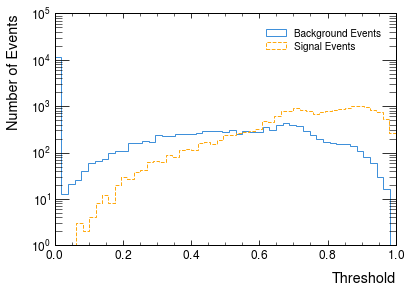

In [44]:
plt.hist(decisions_nn_full[y_test == 0], histtype="step", bins=50, label="Background Events")  # plot background
plt.hist(decisions_nn_full[y_test == 1], histtype="step",bins=50,linestyle="dashed",label="Signal Events",)  # plot signal
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("Number of Events")  # y-axis label
plt.semilogy()  # make the y-axis semi-log
plt.legend()  # draw the legend

In [45]:
fpr_nn_full, tpr_nn_full, thresholds_nn_full = roc_curve(y_test, decisions_nn_full)

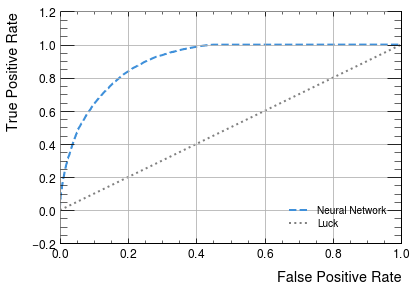

In [46]:
plt.plot(fpr_nn_full, tpr_nn_full, linestyle="dashed", label="Neural Network")  # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
plt.xlabel("False Positive Rate")  # x-axis label
plt.ylabel("True Positive Rate")  # y-axis label
plt.grid()  # add a grid to the plot
plt.legend()

In [47]:
def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS

In [48]:
b_reg = 0.001
ams_nn_full = AMS(tpr_nn_full,fpr_nn_full,b_reg)

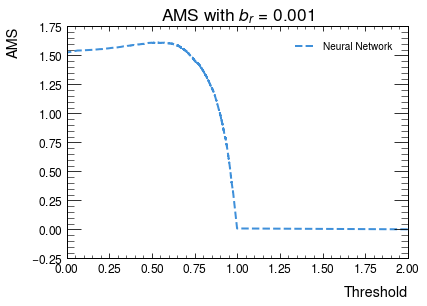

In [49]:
plt.plot(thresholds_nn_full, ams_nn_full, linestyle="dashed", label="Neural Network")  # plot neural network AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title(f"AMS with $b_r$ = {b_reg}")  # add plot title
plt.legend()
plt.show()

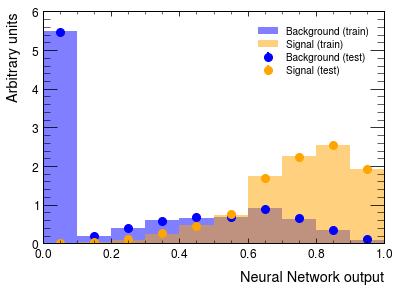

In [50]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
compare_train_test(NN_clf_full, X_train_scaled, y_train, X_test_scaled, y_test, "Neural Network output")

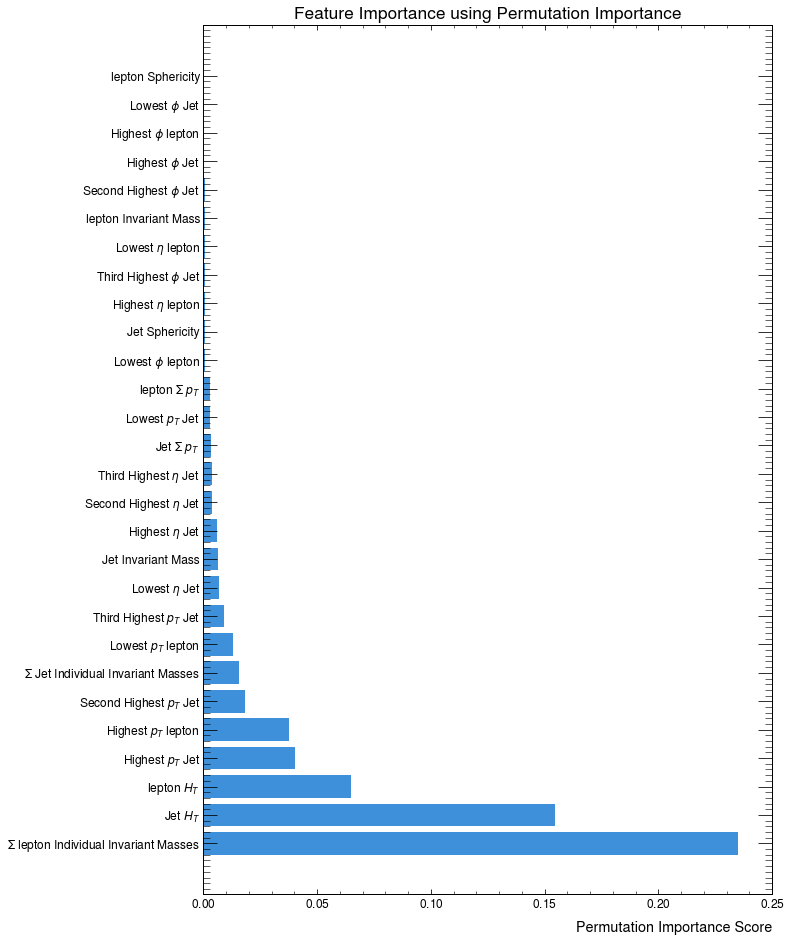

In [51]:
results = permutation_importance(NN_clf_full, X_test_tensor, y_test_tensor, n_repeats=30, random_state=42)
importance_scores = results.importances_mean

feature_importance = sorted(zip(importance_scores), reverse=True)

sorted_indices = np.argsort(importance_scores)[::-1]
feature_names = feature_names_reduced

sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_importance_scores, align='center')
plt.xlabel('Permutation Importance Score')
plt.title('Feature Importance using Permutation Importance')
plt.show()

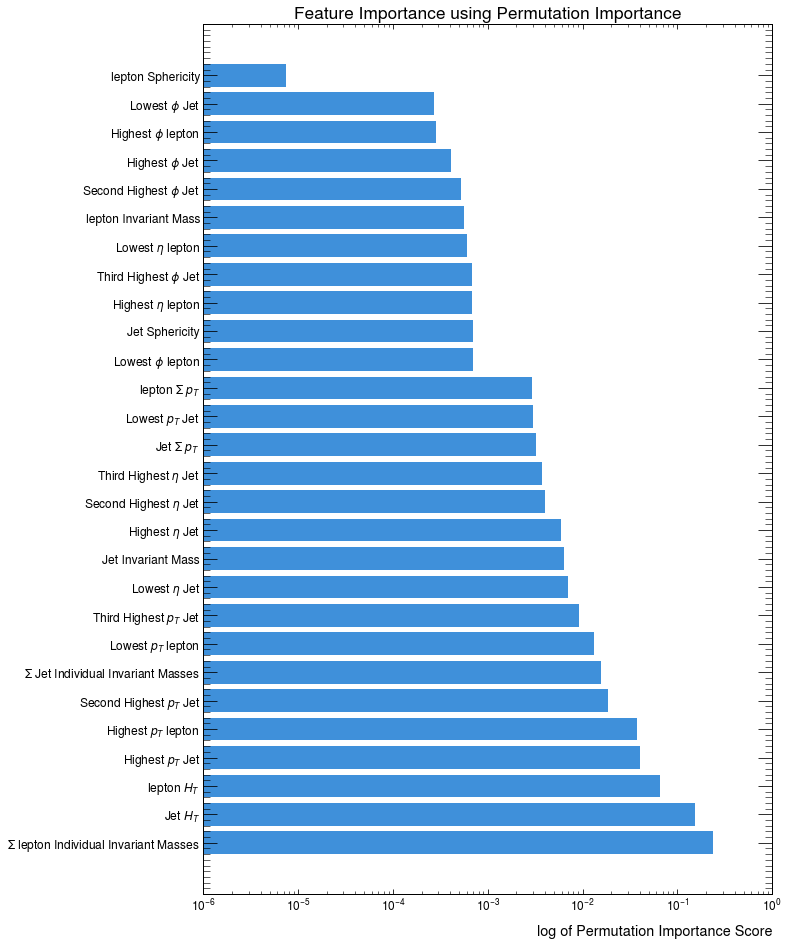

In [52]:
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_importance_scores, align='center')
plt.xlabel('log of Permutation Importance Score')
plt.xscale('log')
plt.title('Feature Importance using Permutation Importance')
plt.show()